# C - *Forstbotanischer Garten* 3D

The present notebook makes use of a metereological dataset made publicly available by the **Forstbotanischer Garten Eberswalde**, the Forest Botanical Garden of the **HNEE**.

The website of the Garden has further informations about the garden:
https://www.hnee.de/en/University/Central-Facilities/Forest-Botanical-Garden/Forstbotanischer-Garten-Eberswalde-E2168.htm?cb=1570965070

The dataset itself can be accessed as tables under the Menu *Stationen* on the website:
http://fobo.hnee.de/

This notebook is organized as follows:
* Short presentation of the data
* Selection of a subset of the data to run the PCA algorithm on: Air temperature, soil temperature and PAR radiation, measured in the Station #4
* Run the PCA algorithm and show:
    * Scaling of the data prior to the analysis
    * Variance explained by the components and *scree* plot

## Import libraries

In [3]:
# To have interactive plots
%matplotlib notebook 

# To have static plots
# %matplotlib inline

import numpy
import pandas
from matplotlib import pyplot

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

numpy.set_printoptions( precision=4, suppress=True )

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Read and describe data

The data table **foboga.csv** was integrated with data from the individual measuring stations in the Forstbotanischer Garten (they are reported individually). There are 7 measuring stations in total:

1. Buche Jungbestand - Young beech (*Fagus sylvatica*)
1. Buche Altbestand - Old beech (*Fagus sylvatica*)
1. Kiefer Jungbestand - Young pine (*Pinus*)
1. Waldlichtung - Clearing, glade
1. Kiefer-Buche-Mischbestand - Mixed beech and pine
1. Kiefer Altbestand - Old pine
1. Experimental station, lysimeters

From these stations, only 1 to 6 are included in the data table, because not all of them have (exactly) the same measurements, particularly Station #7.


The following diagram is also provided by the botanical garden, in particular for the sensor arrangement in Station #4.

<img src='../img/statid_4.png' width='300'>

The data table we will use contains meteorolomeasurements from 1 semester, from 
The meteorological data we will use spans over a complete semester in intervals of 1 hour. It contains the following columns, for stations 1 to 6:
* Timestamp of the measurement
* Air temperature at 2m height
* Relative humidity at 2m height
* PAR radiation at 2m height
* Soil temperature at 25cm depth
* Soil moisture at 25cm depth
* Soil temperature at 55cm depth
* Soil moisture at 55cm depth

For this notebook we will select a subset of those data, to analyse only in 3 dimensions.

### Import data

In [5]:
df = pandas.read_csv( '../data/foboga.csv', parse_dates=['Timestamp'] )
df.set_index( ['Timestamp'], inplace=True, drop=True )

Select only station #4

In [6]:
station_4 = df[ df['Station']==4 ]

Select only 3 columns and show their correlation matrix

PCA works better if there are correlated variables in the data table. It profits from these correlations to construct the new axes. 

In the current example, both the air and soil temperature are correlated and therefore we expect the PCA to yield a good dimensionality reduction.

In [8]:
#datacols = [ 'Temperature (2m)', 'Humidity (2m)', 'PAR Radiation (2m)' ] # Uncomment to analize different variables

datacols = [ 'Temperature (2m)', 'PAR Radiation (2m)', 'Temperature (-0.25m)' ]

station_4 = station_4[ datacols ]

# station_4 = station_4[ station_4['PAR Radiation (2m)']>1 ] # Uncomment to analize during daytime only

station_4.corr()

,Temperature (2m),PAR Radiation (2m),Temperature (-0.25m)
Temperature (2m),1.000000,0.590525,0.868171
PAR Radiation (2m),0.590525,1.000000,0.384050
Temperature (-0.25m),0.868171,0.384050,1.000000


A run plot of all three variables makes these correlations easier to see: Radiation and temperature have both higher values in summer than in winter, and during the day than in the night. Also, the soil temperature is much more stable than the air temperature.

<IPython.core.display.Javascript object>


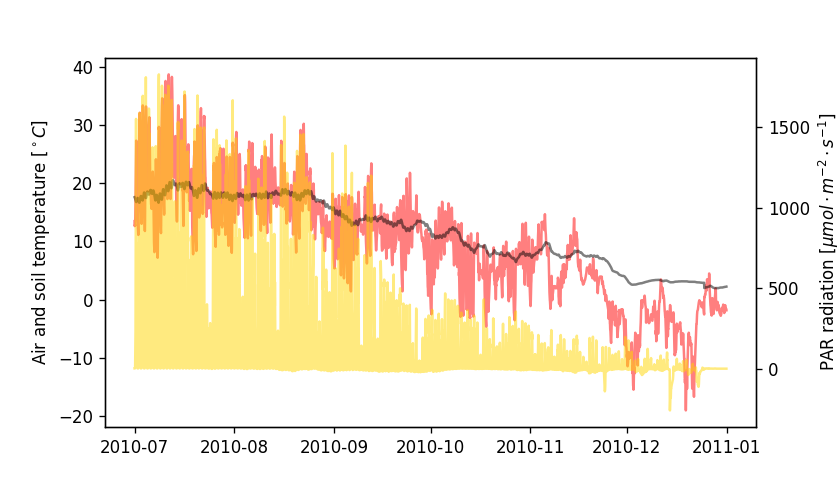

In [32]:
fig, ax =  pyplot.subplots( figsize=(7,4) )

ax.plot( station_4['Temperature (2m)'], color='red', alpha=0.5 )
ax.plot( station_4['Temperature (-0.25m)'], color='black', alpha=0.5 )

axR = ax.twinx()
axR.yaxis.tick_right()
axR.plot( station_4['PAR Radiation (2m)'], color='gold', alpha=0.5 )

ax.set_ylabel( 'Air and soil temperature $[^\circ C]$' )
axR.set_ylabel( 'PAR radiation $[\mu mol \cdot m^{-2} \cdot s^{-1}]$' )

pyplot.show()

Plot a 3D diagram

<IPython.core.display.Javascript object>


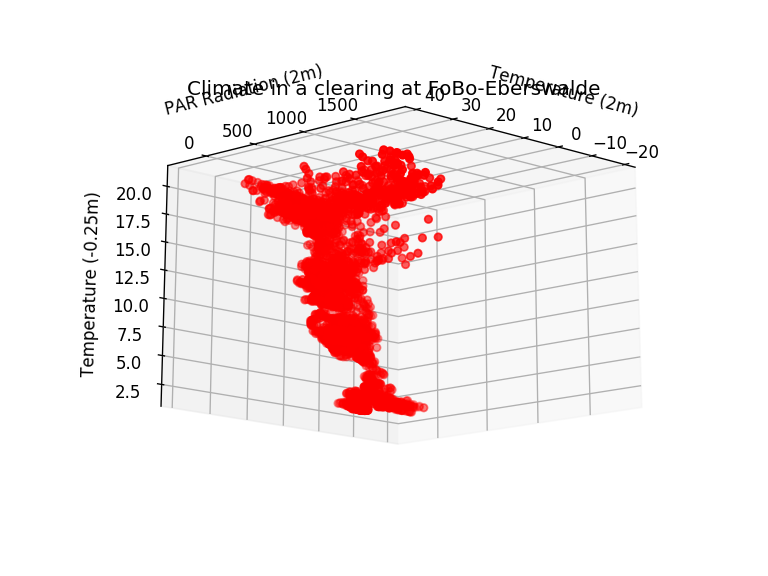

In [33]:
fig = pyplot.figure()
ax = fig.add_subplot(111, projection='3d')

#x = station_4[ 'Temperature (2m)' ]
#y = station_4[ 'Humidity (2m)' ]
#z = station_4[ 'PAR Radiation (2m)' ]

x = station_4[ datacols[0] ]
y = station_4[ datacols[1] ]
z = station_4[ datacols[2] ]

ax.scatter(x, y, z, c='r', marker='o')

#ax.set_xlabel( 'Temperature (2m)' )
#ax.set_ylabel( 'Humidity (2m)' )
#ax.set_zlabel( 'PAR Radiation (2m)' )

ax.set_xlabel( datacols[0] )
ax.set_ylabel( datacols[1] )
ax.set_zlabel( datacols[2] )


pyplot.title( 'Climate in a clearing at FoBo-Eberswalde' )

pyplot.show()

## PCA

### Scaling

Since the temperature and radiation have very different ranges, it is needed to scale them before running the PCA. If the data were not scaled, the variable with the biggest variance would dominate the analysis and bias the components towards it.

In [24]:
scaler = StandardScaler()
scaler.fit( station_4 )
# print( scaler.mean_, scaler.var_ )
scaled_data = scaler.transform( station_4 )

### PCA decomposition

Once the data is scaled (in this case using the mean and standard deviation) it is possible to apply the PCA decomposition:

In [25]:
pca = PCA()
pca.fit( scaled_data )

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [26]:
pca.components_

array([[ 0.6415,  0.4853,  0.5942],
       [-0.1703,  0.8453, -0.5065],
       [ 0.748 , -0.2237, -0.6248]])

The explained variance refers to the total variance of the scaled data. It is often more useful to examine the variance *ratio* (with regard to the total variance), and the cummulative explained variance, to decide if the data can be compressed to a number of principal components.

In [27]:
pca.explained_variance_

array([2.2514, 0.6511, 0.0982])

In [80]:
pca.explained_variance_ratio_

array([0.7503, 0.217 , 0.0327])

In [28]:
pca.explained_variance_ratio_.cumsum()

array([0.7503, 0.9673, 1.    ])

### Scree plot

The following graph shows the contribution of the three principal components to the variance in the original dataset from the station #4.

The red line shows the cummulative explained variance, which is 96% with the first two components.

The dashed black lines mark the 95% and 99% lines, as a reference.

The blue line, plotted on the right-hand axis, is sometimes called *scree plot*, and plots the eigenvalues of the PCA decomposition. It helps to select an amount of components to keep in a compressed table. This is not very well seen in this example, as there are only 3 variables in the original dataset. In cases where a big number of components is calculated, it is often the case that the last eigenvalues drop to (near) zero, making it easy to visualize and therefore decide to leave them out o further analyses.

<IPython.core.display.Javascript object>


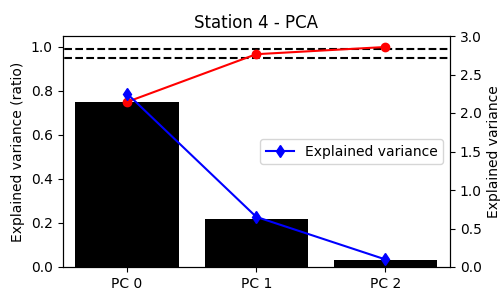

In [30]:
fig, ax = pyplot.subplots( nrows=1, ncols=1, figsize=(5,3) )

ax.bar( list( range( 3 )), pca.explained_variance_ratio_, color='black' )
ax.plot( list( range( 3 )), pca.explained_variance_ratio_.cumsum(), '-', marker='o', color='red' )
ax.hlines( 0.95, -1, 7, linestyle='--', color='black' )
ax.hlines( 0.99, -1, 7, linestyle='--', color='black' )

axR = ax.twinx()
axR.yaxis.tick_right()
axR.plot( list( range( 3 )), pca.explained_variance_, '-', marker='d', color='blue', label='Explained variance' )
axR.set_ylim( [0,3] )

ax.set_xticks( list( range( 3 )) )
ax.set_xticklabels( [ 'PC '+str(i) for i in range(3) ] )

ax.set_ylabel( 'Explained variance (ratio)' )
axR.set_ylabel( 'Explained variance' )

axR.legend( loc='center right' )

ax.set_xlim( [-0.5, 2.5] )
pyplot.title( 'Station 4 - PCA' )
#pyplot.savefig( './scree/Station ' + str(station_n) + '_scree.png' )

pyplot.show()